In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
"""
包含所有英雄頭像圖片的陣列。
維度分別為 (n_champions, height, width, channel)
"""

images = np.load("lol_champion_images.npy")
print("images.shape:", images.shape)

images.shape: (147, 120, 120, 3)
flatten_images.shape: (147, 43200)


* 147 張頭像    
* 每張頭像 120 高 × 120 寬    
* 每個像素有 3 個數字（分別代表紅、綠、藍的強度）    

In [4]:
flatten_images = np.reshape(images, (images.shape[0], -1))
print("flatten_images.shape:", flatten_images.shape)

flatten_images.shape: (147, 43200)


* 把 images 這個四維陣列（比如 (n_champions, height, width, channel)）重新reshape成二維矩陣。
* images.shape[0] 保持不變（就是 有多少個英雄），
* 後面的 -1 表示「自動計算剩下的所有元素數量」，展平成一個長的向量。

-> 147 張圖片（147 位英雄）X 每張圖片被攤平成 43,200 個數字

In [16]:
random_state = 9527
pca = PCA(n_components=108, 
          random_state=random_state)

# 我們可以建構一個標準化 -> 降維的 pipeline
pipe = make_pipeline(StandardScaler(), pca) 
transformed_images = pca.fit_transform(flatten_images)
print("transformed_images.shape:", transformed_images.shape)

transformed_images.shape: (147, 108)


In [18]:
# 將有 43,200 像素的圖片降到 108 維度
print(f'{(108 / 43200) *100} %')
# 用原本的 0.25% 的維度數目

0.25 %


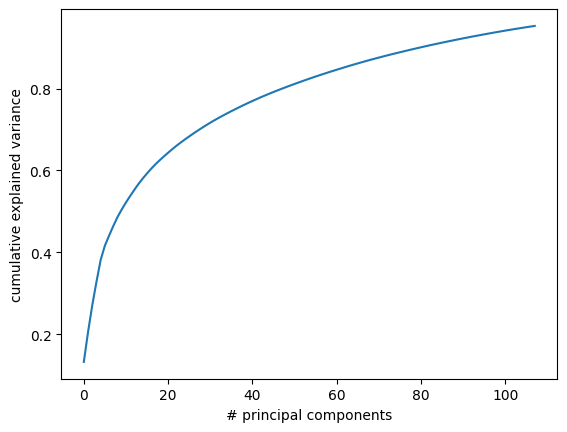

In [9]:
"""
計算主成分累積的疊加變異解釋率
"""
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance');

前 30 個主成分就幾乎解釋了 70% 的數據變異。每個主成分自身就代表著一個在 43200 維度裡頭的高維向量

# 將前 30 個英雄頭像圖片的主成分 rescale 並繪出

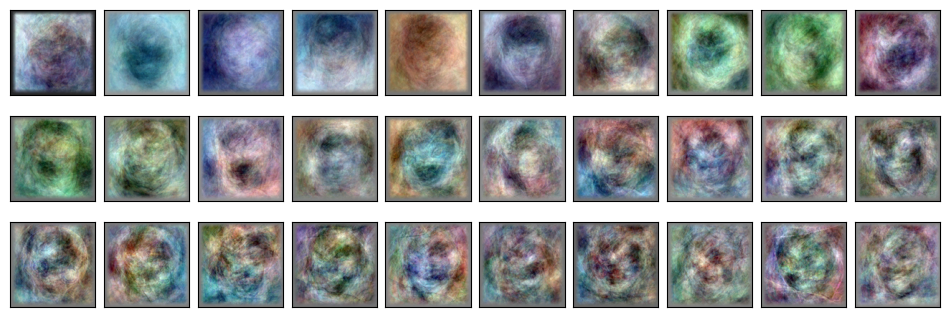

In [19]:
# 為了方便視覺解讀 rescale 主成分
from sklearn.preprocessing import minmax_scale
scaled_comps = minmax_scale(pca.components_, axis=1)

# 繪製前 30 個主成分
fig, axes = plt.subplots(3, 10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    c = scaled_comps[i]
    ax.imshow(c.reshape(120, 120, 3))

# 將新得到的 108 維主成分表徵重新投影回原來 43200 維的像素空間看看重建成果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


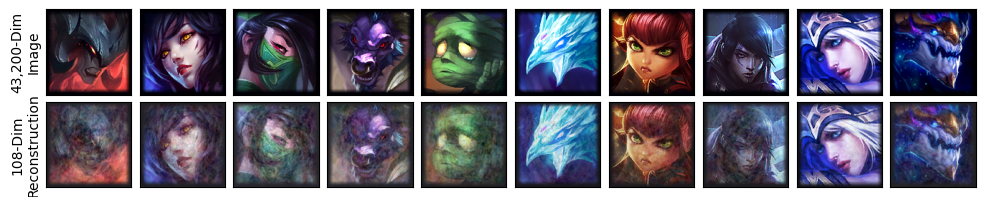

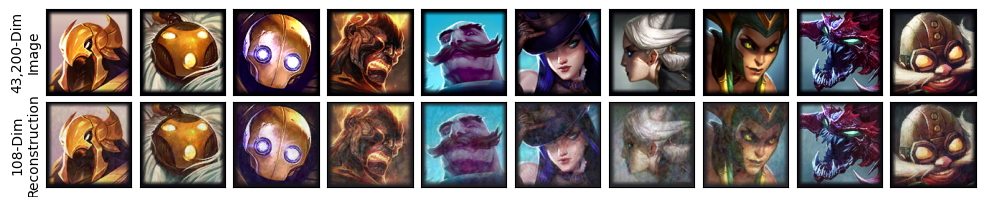

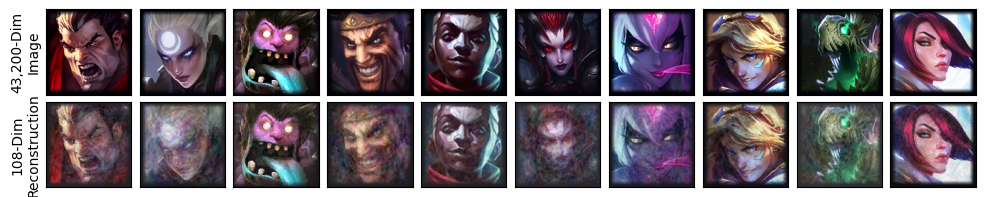

In [20]:
"""
將新得到的 108 維成分表徵重新投影回原高維空間並比較前後結果
"""

# 1. 還原圖片並做正規化

# 用 PCA 的逆轉換（inverse_transform）還原回 43200維，得到一個接近原始圖片但經過壓縮資訊損失的重建版。
reconstructed_images = pca.inverse_transform(transformed_images) 

# 把還原後的數值做 min-max 正規化，把每一張圖的像素值縮到 [0, 1] 的範圍內（axis=1代表每一列，也就是每張圖各自正規化）
reconstructed_images = minmax_scale(reconstructed_images, axis=1) 

# 2. 設定圖像 shape

# 把圖片恢復成 **120 高 × 120 寬 × 3色頻（RGB）**的形狀。
shape = (120, 120, 3) 

# 3. 繪圖
for i in range(3):
    fig, ax = plt.subplots(2, 10, figsize=(12, 6),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=-0.75, wspace=0.1))
    
    for j in range(10):
        idx = i * 10 + j
        
        ax[0, j].imshow(images[idx].reshape(shape))
        ax[1, j].imshow(reconstructed_images[idx].reshape(shape))

    ax[0, 0].set_ylabel('43,200-Dim\nImage')
    ax[1, 0].set_ylabel('108-Dim\nReconstruction');

* 原圖 vs 重建圖的比較可以：

1. 視覺化 PCA 壓縮的效果
2. 看資訊損失是否嚴重
3. 判斷降維的特徵數量夠不夠（如果還原圖模糊，代表特徵數太少）